In [1]:
import os
import sys
from glob import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F

import cv2
import monai
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    RandFlipd,
    RandShiftIntensityd,
    RandRotate90d,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
import SimpleITK as sitk
from scipy.spatial.distance import directed_hausdorff

from TransUNet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from TransUNet.networks.vit_seg_modeling import VisionTransformer as ViT_seg

In [2]:
def dice_coefficient(y_pred, y_true):
    intersection = torch.sum(y_pred * y_true)
    union = torch.sum(y_pred) + torch.sum(y_true) + 1e-6

    dice = 2 * intersection / union

    return dice

In [3]:
def multi_dice_coefficient(output, target):
    dice = torch.zeros(3)
    for i in range(3):
        output_i = (output == i+1)
        target_i = (target == i+1)
        
        intersection = torch.sum(output_i * target_i)
        union = torch.sum(output_i) + torch.sum(target_i) + 1e-6
        
        dice[i] = 2 * intersection / union
    
    return dice

In [4]:
class CustomDataset():
    def __init__(self, data_list, transform=None, split='train'):
        self.datalist = data_list
        self.transform = transform
        self.split = split

    def __getitem__(self, index):
        image_path = self.datalist[index]['img']
        mask_path = self.datalist[index]['mask']
        img = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.split=='train':
            # random Rotation
            if np.random.rand() > 0.5:
                angle = np.random.randint(-15, 15)
                img = F.rotate(img, angle)
                mask = F.rotate(mask, angle)
            # Random horizontal flip
            if np.random.rand() > 0.5:
                img = F.hflip(img)
                mask = F.hflip(mask)
        
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

    def __len__(self):
        return len(self.datalist)

# -------------------------
# Task 1 UNet

In [5]:
images = sorted(glob(os.path.join("images/", "*.png")))
masks = sorted(glob(os.path.join("masks/", "*.png")))
print("There are: {} image and {} masks.".format(len(images), len(masks)))
data_list = [{"img": img, "mask": mask} for img, mask in zip(images, masks)]

# Dataset split: 0.7 train, 0.1 validation, 0.2 test
num_train = int(0.7*len(images))
num_test = int(0.2*len(images))
num_val = len(images)-num_train-num_test
print("Suppose to have {} for train, {} for validation and {} for test.".format(num_train, num_val, num_test))

train_list = random.sample(data_list, num_train)

for element in train_list:
    data_list.remove(element)

val_list = random.sample(data_list, num_val)

for element in val_list:
    data_list.remove(element)
test_list = data_list

print("In fact there are: {} for train, {} for validation and {} for test.".format(len(train_list), len(val_list), len(test_list)))

There are: 21165 image and 21165 masks.
Suppose to have 14815 for train, 2117 for validation and 4233 for test.
In fact there are: 14815 for train, 2117 for validation and 4233 for test.


In [6]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

trainset = CustomDataset(train_list, transform=train_transform, split='train')
train_loader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=0)
valset = CustomDataset(val_list, transform=train_transform, split='train')
val_loader = DataLoader(valset, batch_size=16, shuffle=True, num_workers=0)

In [7]:
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=0,
).cuda()

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [11]:
# UNet training
total_epoch = 20
best_dice = 0.0

print('Begin to train!!')
for epoch in range(total_epoch):
    model.train()
    epoch_loss = 0.0
    batch_idx = 0
    for img, mask in tqdm(train_loader):
        batch_idx += 1
        img, mask = img.cuda(), mask.cuda()
        optimizer.zero_grad()
        output = model(img)
        output = torch.sigmoid(output)
        
        loss = loss_function(output, mask)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss = epoch_loss/batch_idx
    print('Epoch {} loss: {}'.format(epoch, epoch_loss))

    if (epoch + 1) % 5 == 0:
        model.eval()
        print('Begin to validate!!')
        with torch.no_grad():
            val_img = None
            val_mask = None
            val_output = None
            val_loss = 0.0
            val_dice = 0.0
            val_idx = 0
            for val_img, val_mask in tqdm(val_loader):
                val_idx += 1
                val_img, val_mask = val_img.cuda(), val_mask.cuda()
                val_output = model(val_img)
                val_output = torch.sigmoid(val_output)

                loss = loss_function(val_output, val_mask)
                val_loss += loss.item()
                val_dice += dice_coefficient(val_output, val_mask)
        val_loss = val_loss/val_idx
        val_dice = val_dice/val_idx
        print('Validation ended !!') 
        print('Dice: {}, Loss: {}'.format(val_dice, val_loss))
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), 'UNet_model.pth')
            
print('Training ended !!')         

Begin to train!!


100%|██████████| 926/926 [01:04<00:00, 14.36it/s]


Epoch 0 loss: 0.09503233132654595


100%|██████████| 926/926 [01:00<00:00, 15.41it/s]


Epoch 1 loss: 0.040529264577666445


100%|██████████| 926/926 [00:59<00:00, 15.53it/s]


Epoch 2 loss: 0.03133895670991093


100%|██████████| 926/926 [00:59<00:00, 15.55it/s]


Epoch 3 loss: 0.02759591880662781


100%|██████████| 926/926 [00:59<00:00, 15.56it/s]


Epoch 4 loss: 0.026315758603204596
Begin to validate!!


100%|██████████| 133/133 [00:08<00:00, 15.79it/s]


Validation ended !!
Dice: 0.968122124671936, Loss: 0.02608967218127914


100%|██████████| 926/926 [01:27<00:00, 10.63it/s]


Epoch 5 loss: 0.024371687459636714


100%|██████████| 926/926 [00:59<00:00, 15.54it/s]


Epoch 6 loss: 0.02315916897845706


100%|██████████| 926/926 [01:36<00:00,  9.62it/s]


Epoch 7 loss: 0.022370320170530426


100%|██████████| 926/926 [01:03<00:00, 14.63it/s]


Epoch 8 loss: 0.021381842058964606


100%|██████████| 926/926 [01:07<00:00, 13.76it/s]


Epoch 9 loss: 0.02157202807051928
Begin to validate!!


100%|██████████| 133/133 [00:07<00:00, 16.74it/s]


Validation ended !!
Dice: 0.9725534915924072, Loss: 0.022276286708008974


100%|██████████| 926/926 [01:44<00:00,  8.90it/s]


Epoch 10 loss: 0.02010015057415961


100%|██████████| 926/926 [01:00<00:00, 15.33it/s]


Epoch 11 loss: 0.019489687784991307


100%|██████████| 926/926 [01:00<00:00, 15.31it/s]


Epoch 12 loss: 0.019264497705705094


100%|██████████| 926/926 [00:59<00:00, 15.50it/s]


Epoch 13 loss: 0.019108548705097986


100%|██████████| 926/926 [01:00<00:00, 15.39it/s]


Epoch 14 loss: 0.01841977450163878
Begin to validate!!


100%|██████████| 133/133 [00:07<00:00, 16.63it/s]


Validation ended !!
Dice: 0.9756850600242615, Loss: 0.02062943917384049


100%|██████████| 926/926 [00:59<00:00, 15.44it/s]


Epoch 15 loss: 0.01821139124855721


100%|██████████| 926/926 [00:59<00:00, 15.54it/s]


Epoch 16 loss: 0.018167416912103253


100%|██████████| 926/926 [01:09<00:00, 13.36it/s]


Epoch 17 loss: 0.017439085594931573


100%|██████████| 926/926 [01:02<00:00, 14.86it/s]


Epoch 18 loss: 0.017150688752507866


100%|██████████| 926/926 [01:16<00:00, 12.04it/s]


Epoch 19 loss: 0.016779662645975083
Begin to validate!!


100%|██████████| 133/133 [00:07<00:00, 16.64it/s]

Validation ended !!
Dice: 0.9750252962112427, Loss: 0.02084910408838799
Training ended !!


100%|██████████| 265/265 [00:26<00:00, 10.06it/s]


During test, the average Dice is: 0.98553067445755, HD: 2.9675347359599358 pixels.


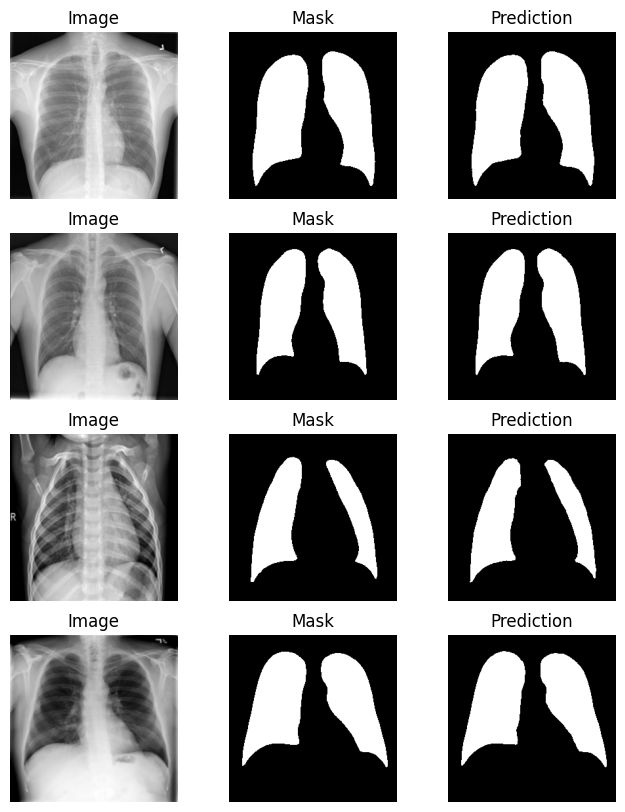

In [8]:
# UNet test
model.load_state_dict(torch.load('UNet_model.pth'))
model.cuda()

# Test set and test loader
testset = CustomDataset(test_list, transform=train_transform, split='test')
test_loader = DataLoader(testset, batch_size=16, shuffle=True, num_workers=0)

batch_idx = 0
test_dice = 0.0
test_hd = 0.0

for img, mask in tqdm(test_loader):
    batch_idx += 1
    img, mask = img.cuda(), mask.cuda()

    output = model(img)
    output = torch.sigmoid(output)
    output = torch.where(output > 0.5, torch.tensor(1).cuda(), torch.tensor(0).cuda())
    
    test_dice += dice_coefficient(output, mask)
    hd_output = output.cpu().detach().numpy().squeeze()
    hd_mask = mask.cpu().detach().numpy().squeeze()
    
    hd = 0.0
    for i in range(output.shape[0]):
        hd += directed_hausdorff(hd_output[i], hd_mask[i])[0]
    test_hd += hd/output.shape[0]

# Quantative Results
test_dice = test_dice/batch_idx
test_hd = test_hd/batch_idx
print('During test, the average Dice is: {}, HD: {} pixels.'.format(test_dice, test_hd))
# Qualitative Results
img_display = img.cpu().detach().numpy()[-4:].squeeze()
mask_display = mask.cpu().detach().numpy()[-4:].squeeze()
output_display = output.cpu().detach().numpy()[-4:].squeeze()

plt.figure(figsize=(8, 10))

for i in range(img_display.shape[0]):
    plt.subplot(4, 3, i*3+1)
    plt.imshow(img_display[i], cmap='gray')
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(4, 3, i*3+2)
    plt.imshow(mask_display[i], cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(4, 3, i*3+3)
    plt.imshow(output_display[i], cmap='gray')
    plt.title('Prediction')
    plt.axis('off')
plt.savefig('Covid_UNet.png')
plt.show()

# -------------------------
# Task 2 TransUNet

In [9]:
vit_name = 'R50-ViT-B_16'
config_vit = CONFIGS_ViT_seg[vit_name]
config_vit.n_classes = 1
config_vit.n_skip = 3

model = ViT_seg(config_vit, img_size=256, num_classes=1).cuda()
load_path = config_vit.pretrained_path.split('..')[-1]
load_path = 'TransUNet' + load_path

model.load_from(weights=np.load(load_path))
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

load_pretrained: grid-size from 14 to 16


In [ ]:
# TransUNet training
total_epoch = 20
best_dice = 0.0

for epoch in range(total_epoch):
    model.train()
    epoch_loss = 0.0
    batch_idx = 0
    for img, mask in tqdm(train_loader):
        batch_idx += 1
        img, mask = img.cuda(), mask.cuda()
        optimizer.zero_grad()
        output = model(img)
        output = torch.sigmoid(output)
        
        loss = loss_function(output, mask)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss = epoch_loss/batch_idx
    print('Epoch {} loss: {}'.format(epoch, epoch_loss))

    if (epoch + 1) % 10 == 0:
        model.eval()
        print('Begin to validate!!')
        with torch.no_grad():
            val_img = None
            val_mask = None
            val_output = None
            val_loss = 0.0
            val_dice = 0.0
            val_idx = 0
            for val_img, val_mask in tqdm(val_loader):
                val_idx += 1
                val_img, val_mask = val_img.cuda(), val_mask.cuda()
                val_output = model(val_img)
                val_output = torch.sigmoid(val_output)

                loss = loss_function(val_output, val_mask)
                val_loss += loss.item()
                val_dice += dice_coefficient(val_output, val_mask)
        val_loss = val_loss/val_idx
        val_dice = val_dice/val_idx
        print('Validation ended !!') 
        print('Dice: {}, Loss: {}'.format(val_dice, val_loss))
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), 'TransUNet_model.pth')
            
print('Training ended !!')   

100%|██████████| 926/926 [04:27<00:00,  3.46it/s]


Epoch 0 loss: 0.0548012756981905


100%|██████████| 926/926 [04:27<00:00,  3.46it/s]


Epoch 1 loss: 0.028896530319737435


100%|██████████| 926/926 [04:27<00:00,  3.46it/s]


Epoch 2 loss: 0.026383489061581458


100%|██████████| 926/926 [04:27<00:00,  3.47it/s]


Epoch 3 loss: 0.02426466660384998


100%|██████████| 926/926 [04:27<00:00,  3.46it/s]


Epoch 4 loss: 0.022691425547550874


100%|██████████| 926/926 [04:26<00:00,  3.47it/s]


Epoch 5 loss: 0.021682833137340665


100%|██████████| 926/926 [04:27<00:00,  3.46it/s]


Epoch 6 loss: 0.020212777780638465


100%|██████████| 926/926 [04:27<00:00,  3.47it/s]


Epoch 7 loss: 0.019835194066915154


100%|██████████| 926/926 [04:26<00:00,  3.47it/s]


Epoch 8 loss: 0.019222041567863966


100%|██████████| 926/926 [04:27<00:00,  3.47it/s]


Epoch 9 loss: 0.019520387057512675
Begin to validate!!


100%|██████████| 133/133 [00:18<00:00,  7.29it/s]


Validation ended !!
Dice: 0.975091278553009, Loss: 0.019697711655968113


100%|██████████| 926/926 [04:27<00:00,  3.46it/s]


Epoch 10 loss: 0.01788219222477104


100%|██████████| 926/926 [04:26<00:00,  3.47it/s]


Epoch 11 loss: 0.017492082756471298


100%|██████████| 926/926 [04:26<00:00,  3.47it/s]


Epoch 12 loss: 0.017233901488198446


100%|██████████| 926/926 [04:26<00:00,  3.47it/s]


Epoch 13 loss: 0.016728353604159397


100%|██████████| 926/926 [04:26<00:00,  3.47it/s]


Epoch 14 loss: 0.01658105404472248


100%|██████████| 926/926 [04:28<00:00,  3.45it/s]


Epoch 15 loss: 0.016272799421673072


100%|██████████| 926/926 [04:27<00:00,  3.47it/s]


Epoch 16 loss: 0.01587700911598445


100%|██████████| 926/926 [04:27<00:00,  3.46it/s]


Epoch 17 loss: 0.015665572998566517


 83%|████████▎ | 769/926 [03:41<00:45,  3.46it/s]

100%|██████████| 265/265 [00:45<00:00,  5.76it/s]


During test, the average Dice is: 0.9842827916145325, HD: 2.9805134047801376 pixels.


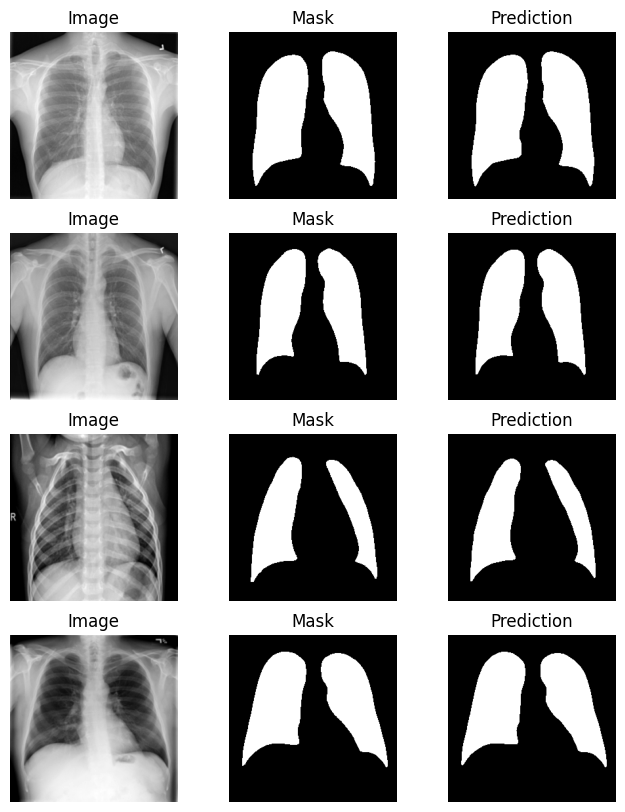

In [10]:
# TransUNet test
model.load_state_dict(torch.load('TransUNet_model.pth'))
model.cuda()

# Test set and test loader
testset = CustomDataset(test_list, transform=train_transform, split='test')
test_loader = DataLoader(testset, batch_size=16, shuffle=True, num_workers=0)

test_idx = 0
test_dice = 0.0
test_hd = 0.0

for img, mask in tqdm(test_loader):
    test_idx += 1
    img, mask = img.cuda(), mask.cuda()

    output = model(img)
    output = torch.sigmoid(output)
    output = torch.where(output > 0.5, torch.tensor(1).cuda(), torch.tensor(0).cuda())

    test_dice += dice_coefficient(output, mask)
    hd_output = output.cpu().detach().numpy().squeeze()
    hd_mask = mask.cpu().detach().numpy().squeeze()
    
    hd = 0.0
    for i in range(output.shape[0]):
        hd += directed_hausdorff(hd_output[i], hd_mask[i])[0]
    test_hd += hd/output.shape[0]

# Quantative Results
test_dice = test_dice/test_idx
test_hd = test_hd/test_idx
print('During test, the average Dice is: {}, HD: {} pixels.'.format(test_dice, test_hd))

# Qualitative Results
img_display = img.cpu().detach().numpy()[-4:].squeeze()
mask_display = mask.cpu().detach().numpy()[-4:].squeeze()
output_display = output.cpu().detach().numpy()[-4:].squeeze()

plt.figure(figsize=(8, 10))

for i in range(img_display.shape[0]):
    plt.subplot(4, 3, i*3+1)
    plt.imshow(img_display[i], cmap='gray')
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(4, 3, i*3+2)
    plt.imshow(mask_display[i], cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(4, 3, i*3+3)
    plt.imshow(output_display[i], cmap='gray')
    plt.title('Prediction')
    plt.axis('off')
plt.savefig('Covid_TransUNet.png')
plt.show()

# ***********************************************************

# Task 4

In [5]:
# Loading training set
nifs = glob('ACDC/training' + "/*/*.nii.gz", recursive=True)
nifs_4d = glob('ACDC/training' + "/*/*4d.nii.gz", recursive=True)
nifs = list(set(nifs)-set(nifs_4d))
nifs_gt = glob('ACDC/training' + "/*/*gt.nii.gz", recursive=True)
nifs_data = list(set(nifs)-set(nifs_gt))
nifs_data = sorted(nifs_data)
nifs_gt = sorted(nifs_gt)
data_list = [{"img": img, "mask": mask} for img, mask in zip(nifs_data, nifs_gt)]

# Dataset split: 0.9 train, 0.1 validation
num_train = int(0.9*len(data_list))

num_val = len(data_list)-num_train
print("Suppose to have {} for train, {} for validation.".format(num_train, num_val))

train_list = random.sample(data_list, num_train)

for element in train_list:
    data_list.remove(element)

val_list = data_list

print("In fact there are: {} for train, {} for validation.".format(len(train_list), len(val_list)))

Suppose to have 180 for train, 20 for validation.
In fact there are: 180 for train, 20 for validation.


In [6]:
# Loading testing set
# Loading training set
nifs = glob('ACDC/testing' + "/*/*.nii.gz", recursive=True)
nifs_4d = glob('ACDC/testing' + "/*/*4d.nii.gz", recursive=True)
nifs = list(set(nifs)-set(nifs_4d))
nifs_gt = glob('ACDC/testing' + "/*/*gt.nii.gz", recursive=True)
nifs_data = list(set(nifs)-set(nifs_gt))
nifs_data = sorted(nifs_data)
nifs_gt = sorted(nifs_gt)
test_list = [{"img": img, "mask": mask} for img, mask in zip(nifs_data, nifs_gt)]
print("There are {} for test.".format(len(test_list)))

There are 100 for test.


In [7]:
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
# Transform
train_transforms = Compose(
    [
        LoadImaged(keys=["img", "mask"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["img"],
            a_min=0,
            a_max=450,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["img", "mask"], source_key="img"),
        Orientationd(keys=["img", "mask"], axcodes="RAS"),
        Spacingd(keys=["img", "mask"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["img", "mask"],
            label_key="mask",
            spatial_size=(192, 192, 32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="img",
            image_threshold=0,
        ),
        RandFlipd(keys=["img", "mask"],spatial_axis=[0],prob=0.10),
        RandFlipd(keys=["img", "mask"],spatial_axis=[1],prob=0.10),
        RandFlipd(keys=["img", "mask"],spatial_axis=[2],prob=0.10),
        RandRotate90d(keys=["img", "mask"],prob=0.10,max_k=3),
        RandShiftIntensityd(keys=["mask"],offsets=0.10,prob=0.50)
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["img", "mask"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["img"],
            a_min=0,
            a_max=450,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["img", "mask"], source_key="img"),
        Orientationd(keys=["img", "mask"], axcodes="RAS"),
        Spacingd(keys=["img", "mask"], pixdim=(1, 1, 1), mode=("bilinear", "nearest"))

    ]
)

/home/hongxu.jiang/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [8]:
train_ds = CacheDataset(data=train_list, transform=train_transforms, cache_rate=1.0, num_workers=8)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8)

val_ds = CacheDataset(data=val_list, transform=val_transforms, cache_rate=1.0, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=8)

# Test set and test loader
test_ds = CacheDataset(data=test_list, transform=val_transforms, cache_rate=1.0, num_workers=8)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8)

Loading dataset: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


# -------------------------
# 3D UNet

In [9]:
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2, 2),
    num_res_units=0,
).cuda()


loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
# start training
total_epoch = 50
best_dice = 0.0

for epoch in range(total_epoch):
    model.train()
    epoch_loss = 0.0
    batch_idx = 0
    for data in tqdm(train_loader):
        batch_idx += 1
        img = data['img'].cuda()
        mask = data['mask'].cuda() 
        
        optimizer.zero_grad()
        output = model(img)
        
        loss = loss_function(output, mask)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    epoch_loss = epoch_loss/batch_idx
    print('Epoch {} loss: {}'.format(epoch, epoch_loss))
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        print('Begin to validate!!')
        with torch.no_grad():
            val_img = None
            val_mask = None
            val_output = None
            val_loss = 0.0
            val_dice = 0.0
            val_dice1 = 0.0
            val_dice2 = 0.0
            val_dice3 = 0.0
            val_idx = 0
            
            for data in tqdm(val_loader):
                val_idx += 1
                val_img = data['img']
                val_mask = data['mask']
                # val_mask = data['mask'].long().squeeze(1)
                # val_mask = nn.functional.one_hot(val_mask, num_classes=4).permute(0, 4, 1, 2, 3).to(torch.float)
                val_img = val_img.cuda()
                val_mask = val_mask.cuda()
                
                roi_size = (192, 192, 32)
                sw_batch_size = 4
                val_output = sliding_window_inference(val_img, roi_size, sw_batch_size, model)
                
                loss = loss_function(val_output, val_mask)
                
                val_loss += loss.item()            
                val_output = torch.softmax(val_output, dim=1)
                val_output = torch.argmax(val_output, dim=1, keepdim=True)
                dice1, dice2, dice3 = dice_coefficient(val_output.squeeze(), val_mask.squeeze())
                val_dice1 += dice1
                val_dice2 += dice2
                val_dice3 += dice3
                
            val_loss = val_loss/val_idx
            val_dice1 = val_dice1/val_idx
            val_dice2 = val_dice2/val_idx
            val_dice3 = val_dice3/val_idx
            val_dice = (val_dice1+val_dice2+val_dice3)/3
            print('Validation ended !!')
            print('Mean Dice: {}, Loss: {}'.format(val_dice, val_loss))

            if val_dice > best_dice:
                best_dice = val_dice
                torch.save(model.state_dict(), '3DUNet_model.pth')
            print('End of Validation-----------------------')
            
print('Training ended !!')  

100%|██████████| 180/180 [00:15<00:00, 11.86it/s]


Epoch 0 loss: 1.8672101259231568


100%|██████████| 180/180 [00:14<00:00, 12.04it/s]


Epoch 1 loss: 1.383143852154414


100%|██████████| 180/180 [00:15<00:00, 11.94it/s]


Epoch 2 loss: 1.1662540607982212


100%|██████████| 180/180 [00:14<00:00, 12.13it/s]


Epoch 3 loss: 1.045897019571728


100%|██████████| 180/180 [00:15<00:00, 11.93it/s]


Epoch 4 loss: 0.9773396097951466


100%|██████████| 180/180 [00:14<00:00, 12.25it/s]


Epoch 5 loss: 0.9229442261987262


100%|██████████| 180/180 [00:14<00:00, 12.10it/s]


Epoch 6 loss: 0.8962115516265233


100%|██████████| 180/180 [00:14<00:00, 12.34it/s]


Epoch 7 loss: 0.8533180319600635


100%|██████████| 180/180 [00:13<00:00, 13.17it/s]


Epoch 8 loss: 0.8300877978404363


100%|██████████| 180/180 [00:13<00:00, 13.11it/s]


Epoch 9 loss: 0.8111218452453614
Starting Validation-----------------------


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Mean Validation Dice: 0.5371374487876892, Loss: 0.6504422485828399
End of Validation-----------------------


100%|██████████| 180/180 [00:13<00:00, 12.96it/s]


Epoch 10 loss: 0.7680586208899816


100%|██████████| 180/180 [00:13<00:00, 13.02it/s]


Epoch 11 loss: 0.7462195061975055


100%|██████████| 180/180 [00:13<00:00, 13.29it/s]


Epoch 12 loss: 0.7097534366779857


100%|██████████| 180/180 [00:13<00:00, 12.91it/s]


Epoch 13 loss: 0.6918285606635941


100%|██████████| 180/180 [00:13<00:00, 13.20it/s]


Epoch 14 loss: 0.6644858760966195


100%|██████████| 180/180 [00:13<00:00, 12.86it/s]


Epoch 15 loss: 0.6515373340911336


100%|██████████| 180/180 [00:13<00:00, 12.99it/s]


Epoch 16 loss: 0.6144591094719039


100%|██████████| 180/180 [00:13<00:00, 13.20it/s]


Epoch 17 loss: 0.6326092051135169


100%|██████████| 180/180 [00:13<00:00, 13.39it/s]


Epoch 18 loss: 0.5924147503243552


100%|██████████| 180/180 [00:13<00:00, 13.28it/s]


Epoch 19 loss: 0.603132045103444
Starting Validation-----------------------


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Mean Validation Dice: 0.7378905415534973, Loss: 0.3963545948266983
End of Validation-----------------------


100%|██████████| 180/180 [00:13<00:00, 13.18it/s]


Epoch 20 loss: 0.586242697139581


100%|██████████| 180/180 [00:13<00:00, 13.15it/s]


Epoch 21 loss: 0.5840219489402241


100%|██████████| 180/180 [00:13<00:00, 13.57it/s]


Epoch 22 loss: 0.5569499863518609


100%|██████████| 180/180 [00:13<00:00, 13.12it/s]


Epoch 23 loss: 0.5902823633617825


100%|██████████| 180/180 [00:13<00:00, 13.24it/s]


Epoch 24 loss: 0.5484334652622541


100%|██████████| 180/180 [00:13<00:00, 13.22it/s]


Epoch 25 loss: 0.5493065838184622


100%|██████████| 180/180 [00:13<00:00, 13.15it/s]


Epoch 26 loss: 0.5423600137233734


100%|██████████| 180/180 [00:13<00:00, 13.38it/s]


Epoch 27 loss: 0.5476702688468827


100%|██████████| 180/180 [00:13<00:00, 13.27it/s]


Epoch 28 loss: 0.5447721294230885


100%|██████████| 180/180 [00:13<00:00, 13.04it/s]


Epoch 29 loss: 0.520898100733757
Starting Validation-----------------------


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Mean Validation Dice: 0.7813732028007507, Loss: 0.3041668854653835
End of Validation-----------------------


100%|██████████| 180/180 [00:13<00:00, 13.21it/s]


Epoch 30 loss: 0.5154996403389507


100%|██████████| 180/180 [00:13<00:00, 13.17it/s]


Epoch 31 loss: 0.5236200422876411


100%|██████████| 180/180 [00:13<00:00, 13.20it/s]


Epoch 32 loss: 0.519003962063127


100%|██████████| 180/180 [00:13<00:00, 13.48it/s]


Epoch 33 loss: 0.5150892200569311


100%|██████████| 180/180 [00:13<00:00, 13.18it/s]


Epoch 34 loss: 0.5181598660846551


100%|██████████| 180/180 [00:13<00:00, 13.44it/s]


Epoch 35 loss: 0.4968821410503652


100%|██████████| 180/180 [00:13<00:00, 13.52it/s]


Epoch 36 loss: 0.4969239817725288


100%|██████████| 180/180 [00:13<00:00, 13.07it/s]


Epoch 37 loss: 0.4975061646766133


100%|██████████| 180/180 [00:13<00:00, 13.24it/s]


Epoch 38 loss: 0.5181927983959516


100%|██████████| 180/180 [00:13<00:00, 13.41it/s]


Epoch 39 loss: 0.5324150163266393
Starting Validation-----------------------


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Mean Validation Dice: 0.8033738732337952, Loss: 0.2639978416264057
End of Validation-----------------------


100%|██████████| 180/180 [00:13<00:00, 13.01it/s]


Epoch 40 loss: 0.5108773805201053


100%|██████████| 180/180 [00:13<00:00, 13.42it/s]


Epoch 41 loss: 0.4955008074641228


100%|██████████| 180/180 [00:13<00:00, 13.22it/s]


Epoch 42 loss: 0.5052615967061784


100%|██████████| 180/180 [00:13<00:00, 13.27it/s]


Epoch 43 loss: 0.4809900383154551


100%|██████████| 180/180 [00:13<00:00, 13.20it/s]


Epoch 44 loss: 0.5183467518952157


100%|██████████| 180/180 [00:13<00:00, 13.01it/s]


Epoch 45 loss: 0.5202768375476201


100%|██████████| 180/180 [00:13<00:00, 13.56it/s]


Epoch 46 loss: 0.4793717835512426


100%|██████████| 180/180 [00:13<00:00, 12.90it/s]


Epoch 47 loss: 0.4977804426517751


100%|██████████| 180/180 [00:13<00:00, 13.49it/s]


Epoch 48 loss: 0.5029798944791158


100%|██████████| 180/180 [00:13<00:00, 13.06it/s]


Epoch 49 loss: 0.49690038131342995
Starting Validation-----------------------


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]

Mean Validation Dice: 0.8189926147460938, Loss: 0.23226649090647697
End of Validation-----------------------
End of training-------


100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


During test, the average Dice: 0.8111028075218201, HD: 3.488287062736648mm
During test, class 1 ave Dice: 0.779936671257019, class 2 ave Dice: 0.7799513936042786, class 3 ave Dice: 0.8734201788902283
During test, class 1 ave HD: 3.9396332858554364mm, class 2 ave HD: 3.748964134071845mm, class 3 ave HD: 2.776263768282662mm


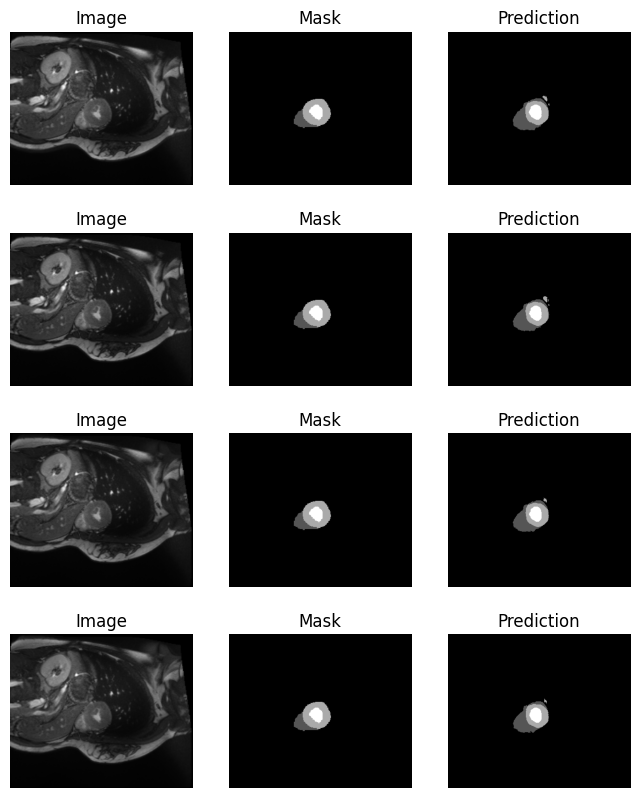

In [12]:
# Test on 3DUNet model and evaluate on Dice and Hausdorff distance
model.load_state_dict(torch.load('3DUNet_model.pth'))
model.cuda()

test_idx = 0
test_dice = 0.0
test_dice1 = 0.0
test_dice2 = 0.0
test_dice3 = 0.0
test_hd1 = 0.0
test_hd2 = 0.0
test_hd3 = 0.0

for data in tqdm(test_loader):
    test_idx += 1
    test_img = data['img']
    test_mask = data['mask']
    test_img = test_img.cuda()
    test_mask = test_mask.cuda()
                
    roi_size = (192, 192, 32)
    sw_batch_size = 4
    test_output = sliding_window_inference(test_img, roi_size, sw_batch_size, model)

    test_output = torch.softmax(test_output, dim=1)
    test_output = torch.argmax(test_output, dim=1, keepdim=True)
    
    dice1, dice2, dice3 = multi_dice_coefficient(test_output.squeeze(), test_mask.squeeze())
    
    hd_output = test_output.squeeze().cpu().detach().numpy()
    hd_mask = test_mask.squeeze().cpu().detach().numpy()

    hd_i = [0.0, 0.0, 0.0]
    for i in range(hd_output.shape[-1]):
        for j in range(3):
            hd_output_i = (hd_output[:,:,i]==j+1)
            hd_mask_i = (hd_mask[:,:,i]==j+1)
            hd_i[j] += directed_hausdorff(hd_output_i, hd_mask_i)[0]
    hd_i[0] = hd_i[0]/hd_output.shape[-1]
    hd_i[1] = hd_i[1]/hd_output.shape[-1]
    hd_i[2] = hd_i[2]/hd_output.shape[-1]
    
    test_dice1 += dice1
    test_dice2 += dice2
    test_dice3 += dice3
    test_hd1 += hd_i[0]
    test_hd2 += hd_i[1]
    test_hd3 += hd_i[2]

# Quantative Results
test_dice1 = test_dice1/test_idx
test_dice2 = test_dice2/test_idx
test_dice3 = test_dice3/test_idx
test_hd1 = test_hd1/test_idx
test_hd2 = test_hd2/test_idx
test_hd3 = test_hd3/test_idx
test_dice = (test_dice1+test_dice2+test_dice3)/3
test_hd = (test_hd1+test_hd2+test_hd3)/3
print('During test, the average Dice: {}, HD: {}mm'.format(test_dice, test_hd))
print('During test, class 1 ave Dice: {}, class 2 ave Dice: {}, class 3 ave Dice: {}'.format(test_dice1, test_dice2, test_dice3))
print('During test, class 1 ave HD: {}mm, class 2 ave HD: {}mm, class 3 ave HD: {}mm'.format(test_hd1, test_hd2, test_hd3))

# Qualitative Results
img_display = test_img.cpu().detach().numpy().squeeze()
mask_display = test_mask.cpu().detach().numpy().squeeze()
output_display = test_output.cpu().detach().numpy().squeeze()

plt.figure(figsize=(8, 10))

plt.subplot(4, 3, 1)
plt.imshow(img_display[:, :, 39], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 2)
plt.imshow(mask_display[:, :, 39], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 3)
plt.imshow(output_display[:, :, 39], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.subplot(4, 3, 4)
plt.imshow(img_display[:, :, 40], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 5)
plt.imshow(mask_display[:, :, 40], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 6)
plt.imshow(output_display[:, :, 40], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.subplot(4, 3, 7)
plt.imshow(img_display[:, :, 41], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 8)
plt.imshow(mask_display[:, :, 41], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 9)
plt.imshow(output_display[:, :, 41], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.subplot(4, 3, 10)
plt.imshow(img_display[:, :, 42], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 11)
plt.imshow(mask_display[:, :, 42], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 12)
plt.imshow(output_display[:, :, 42], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.savefig('3D_UNet.png')
plt.show()

# -------------------------
# 3D ResUNet

In [13]:
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2, 2),
    num_res_units=2,
).cuda()

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [18]:
# start training
total_epoch = 50
best_dice = 0.0

for epoch in range(total_epoch):
    model.train()
    epoch_loss = 0.0
    batch_idx = 0
    for data in tqdm(train_loader):
        batch_idx += 1
        img = data['img'].cuda()
        mask = data['mask'].cuda() 
        
        optimizer.zero_grad()
        output = model(img)
        
        loss = loss_function(output, mask)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    epoch_loss = epoch_loss/batch_idx
    print('Epoch {} loss: {}'.format(epoch, epoch_loss))
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        print('Begin to validate!!')
        with torch.no_grad():
            val_img = None
            val_mask = None
            val_output = None
            val_loss = 0.0
            val_dice = 0.0
            val_dice1 = 0.0
            val_dice2 = 0.0
            val_dice3 = 0.0
            val_idx = 0
            
            for data in tqdm(val_loader):
                val_idx += 1
                val_img = data['img']
                val_mask = data['mask']
                val_img = val_img.cuda()
                val_mask = val_mask.cuda()
                
                roi_size = (192, 192, 32)
                sw_batch_size = 4
                val_output = sliding_window_inference(val_img, roi_size, sw_batch_size, model)
                
                loss = loss_function(val_output, val_mask)
                
                val_loss += loss.item()            
                val_output = torch.softmax(val_output, dim=1)
                val_output = torch.argmax(val_output, dim=1, keepdim=True)
                dice1, dice2, dice3 = dice_coefficient(val_output.squeeze(), val_mask.squeeze())
                val_dice1 += dice1
                val_dice2 += dice2
                val_dice3 += dice3
                
            val_loss = val_loss/val_idx
            val_dice1 = val_dice1/val_idx
            val_dice2 = val_dice2/val_idx
            val_dice3 = val_dice3/val_idx
            val_dice = (val_dice1+val_dice2+val_dice3)/3
            print('Validation ended !!')
            print('Mean Dice: {}, Loss: {}'.format(val_dice, val_loss))

            if val_dice > best_dice:
                best_dice = val_dice
                torch.save(model.state_dict(), '3DResUNet_model.pth')
            print('End of Validation-----------------------')
            
print('Training ended !!')  

100%|██████████| 180/180 [00:17<00:00, 10.11it/s]


Epoch 0 loss: 1.7080930729707082


100%|██████████| 180/180 [00:17<00:00, 10.21it/s]


Epoch 1 loss: 1.1489926705757776


100%|██████████| 180/180 [00:17<00:00, 10.21it/s]


Epoch 2 loss: 0.9675453113185035


100%|██████████| 180/180 [00:17<00:00, 10.15it/s]


Epoch 3 loss: 0.8641885475979911


100%|██████████| 180/180 [00:17<00:00, 10.04it/s]


Epoch 4 loss: 0.8000745707088046


100%|██████████| 180/180 [00:17<00:00, 10.10it/s]


Epoch 5 loss: 0.7436307571000523


100%|██████████| 180/180 [00:17<00:00, 10.02it/s]


Epoch 6 loss: 0.6965467924873034


100%|██████████| 180/180 [00:17<00:00, 10.10it/s]


Epoch 7 loss: 0.6813197190562884


100%|██████████| 180/180 [00:17<00:00, 10.16it/s]


Epoch 8 loss: 0.6270018210013707


100%|██████████| 180/180 [00:17<00:00, 10.09it/s]


Epoch 9 loss: 0.6164717172582944
Starting Validation-----------------------


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Mean Validation Dice: 0.7348387241363525, Loss: 0.3927607908844948
End of Validation-----------------------


100%|██████████| 180/180 [00:17<00:00, 10.18it/s]


Epoch 10 loss: 0.6114138414462408


100%|██████████| 180/180 [00:17<00:00, 10.04it/s]


Epoch 11 loss: 0.5827408370044497


100%|██████████| 180/180 [00:17<00:00, 10.16it/s]


Epoch 12 loss: 0.5578929372959667


100%|██████████| 180/180 [00:17<00:00, 10.08it/s]


Epoch 13 loss: 0.5552604770494832


100%|██████████| 180/180 [00:17<00:00, 10.13it/s]


Epoch 14 loss: 0.5730891843636831


100%|██████████| 180/180 [00:17<00:00, 10.02it/s]


Epoch 15 loss: 0.5195128394497766


100%|██████████| 180/180 [00:17<00:00, 10.10it/s]


Epoch 16 loss: 0.5353987771603796


100%|██████████| 180/180 [00:17<00:00, 10.12it/s]


Epoch 17 loss: 0.5326608687639236


100%|██████████| 180/180 [00:17<00:00, 10.26it/s]


Epoch 18 loss: 0.5460933316085074


100%|██████████| 180/180 [00:17<00:00, 10.17it/s]


Epoch 19 loss: 0.5032540905806754
Starting Validation-----------------------


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Mean Validation Dice: 0.7697718143463135, Loss: 0.3053561106324196
End of Validation-----------------------


100%|██████████| 180/180 [00:17<00:00, 10.18it/s]


Epoch 20 loss: 0.5225808330708079


100%|██████████| 180/180 [00:17<00:00, 10.13it/s]


Epoch 21 loss: 0.5105963030623065


100%|██████████| 180/180 [00:17<00:00, 10.23it/s]


Epoch 22 loss: 0.5303969951967399


100%|██████████| 180/180 [00:17<00:00, 10.20it/s]


Epoch 23 loss: 0.49991802929176227


100%|██████████| 180/180 [00:17<00:00, 10.30it/s]


Epoch 24 loss: 0.46963541184862456


100%|██████████| 180/180 [00:18<00:00,  9.99it/s]


Epoch 25 loss: 0.519929188158777


100%|██████████| 180/180 [00:17<00:00, 10.09it/s]


Epoch 26 loss: 0.4870814035336177


100%|██████████| 180/180 [00:17<00:00, 10.07it/s]


Epoch 27 loss: 0.44691637290848624


100%|██████████| 180/180 [00:17<00:00, 10.02it/s]


Epoch 28 loss: 0.5257647619479232


100%|██████████| 180/180 [00:17<00:00, 10.05it/s]


Epoch 29 loss: 0.5244484581053257
Starting Validation-----------------------


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Mean Validation Dice: 0.8004374504089355, Loss: 0.2751937933266163
End of Validation-----------------------


100%|██████████| 180/180 [00:17<00:00, 10.01it/s]


Epoch 30 loss: 0.48236971646547316


100%|██████████| 180/180 [00:17<00:00, 10.19it/s]


Epoch 31 loss: 0.48821781807475617


100%|██████████| 180/180 [00:17<00:00, 10.13it/s]


Epoch 32 loss: 0.47335538350873524


100%|██████████| 180/180 [00:17<00:00, 10.26it/s]


Epoch 33 loss: 0.4673524287011888


100%|██████████| 180/180 [00:17<00:00, 10.21it/s]


Epoch 34 loss: 0.4978174451324675


100%|██████████| 180/180 [00:17<00:00, 10.01it/s]


Epoch 35 loss: 0.453534254597293


100%|██████████| 180/180 [00:17<00:00, 10.07it/s]


Epoch 36 loss: 0.4867588282459312


100%|██████████| 180/180 [00:17<00:00, 10.08it/s]


Epoch 37 loss: 0.4744119242661529


100%|██████████| 180/180 [00:17<00:00, 10.08it/s]


Epoch 38 loss: 0.4741425131758054


100%|██████████| 180/180 [00:17<00:00, 10.16it/s]


Epoch 39 loss: 0.4588261506623692
Starting Validation-----------------------


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Mean Validation Dice: 0.8283994793891907, Loss: 0.20923161283135414
End of Validation-----------------------


100%|██████████| 180/180 [00:17<00:00, 10.10it/s]


Epoch 40 loss: 0.44848549655742115


100%|██████████| 180/180 [00:17<00:00, 10.20it/s]


Epoch 41 loss: 0.4748872275981638


100%|██████████| 180/180 [00:18<00:00,  9.94it/s]


Epoch 42 loss: 0.4503252641194396


100%|██████████| 180/180 [00:17<00:00, 10.17it/s]


Epoch 43 loss: 0.4487532150414255


100%|██████████| 180/180 [00:17<00:00, 10.26it/s]


Epoch 44 loss: 0.46496785092684956


100%|██████████| 180/180 [00:18<00:00,  9.94it/s]


Epoch 45 loss: 0.4567969539099269


100%|██████████| 180/180 [00:18<00:00,  9.96it/s]


Epoch 46 loss: 0.49758022891150583


100%|██████████| 180/180 [00:17<00:00, 10.20it/s]


Epoch 47 loss: 0.47435335376196436


100%|██████████| 180/180 [00:17<00:00, 10.07it/s]


Epoch 48 loss: 0.48296541828248235


100%|██████████| 180/180 [00:17<00:00, 10.10it/s]


Epoch 49 loss: 0.4511306272612678
Starting Validation-----------------------


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]

Mean Validation Dice: 0.8350708484649658, Loss: 0.20857156813144684
End of Validation-----------------------
End of training-------


100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


During test, the average Dice: 0.8380686640739441, HD: 3.2690811441936525mm
During test, class 1 ave Dice: 0.8200713992118835, class 2 ave Dice: 0.8011590838432312, class 3 ave Dice: 0.8929754495620728
During test, class 1 ave HD: 3.694060983104845mm, class 2 ave HD: 3.525688867374634mm, class 3 ave HD: 2.5874935821014793mm


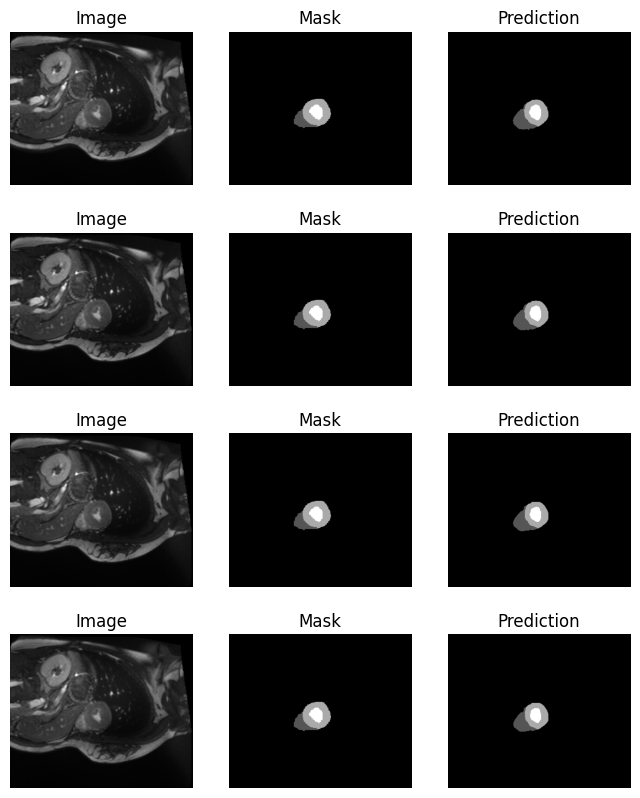

In [14]:
# Test on 3DUNet model and evaluate on Dice and Hausdorff distance
model.load_state_dict(torch.load('3DResUNet_model.pth'))
model.cuda()

test_idx = 0
test_dice = 0.0
test_dice1 = 0.0
test_dice2 = 0.0
test_dice3 = 0.0
test_hd1 = 0.0
test_hd2 = 0.0
test_hd3 = 0.0

for data in tqdm(test_loader):
    test_idx += 1
    test_img = data['img']
    test_mask = data['mask']
    test_img = test_img.cuda()
    test_mask = test_mask.cuda()
                
    roi_size = (192, 192, 32)
    sw_batch_size = 4
    test_output = sliding_window_inference(test_img, roi_size, sw_batch_size, model)

    test_output = torch.softmax(test_output, dim=1)
    test_output = torch.argmax(test_output, dim=1, keepdim=True)
    
    dice1, dice2, dice3 = multi_dice_coefficient(test_output.squeeze(), test_mask.squeeze())
    
    hd_output = test_output.squeeze().cpu().detach().numpy()
    hd_mask = test_mask.squeeze().cpu().detach().numpy()

    hd_i = [0.0, 0.0, 0.0]
    for i in range(hd_output.shape[-1]):
        for j in range(3):
            hd_output_i = (hd_output[:,:,i]==j+1)
            hd_mask_i = (hd_mask[:,:,i]==j+1)
            hd_i[j] += directed_hausdorff(hd_output_i, hd_mask_i)[0]
    hd_i[0] = hd_i[0]/hd_output.shape[-1]
    hd_i[1] = hd_i[1]/hd_output.shape[-1]
    hd_i[2] = hd_i[2]/hd_output.shape[-1]
    
    test_dice1 += dice1
    test_dice2 += dice2
    test_dice3 += dice3
    test_hd1 += hd_i[0]
    test_hd2 += hd_i[1]
    test_hd3 += hd_i[2]

# Quantative Results
test_dice1 = test_dice1/test_idx
test_dice2 = test_dice2/test_idx
test_dice3 = test_dice3/test_idx
test_hd1 = test_hd1/test_idx
test_hd2 = test_hd2/test_idx
test_hd3 = test_hd3/test_idx
test_dice = (test_dice1+test_dice2+test_dice3)/3
test_hd = (test_hd1+test_hd2+test_hd3)/3
print('During test, the average Dice: {}, HD: {}mm'.format(test_dice, test_hd))
print('During test, class 1 ave Dice: {}, class 2 ave Dice: {}, class 3 ave Dice: {}'.format(test_dice1, test_dice2, test_dice3))
print('During test, class 1 ave HD: {}mm, class 2 ave HD: {}mm, class 3 ave HD: {}mm'.format(test_hd1, test_hd2, test_hd3))

# Qualitative Results
img_display = test_img.cpu().detach().numpy().squeeze()
mask_display = test_mask.cpu().detach().numpy().squeeze()
output_display = test_output.cpu().detach().numpy().squeeze()

plt.figure(figsize=(8, 10))

plt.subplot(4, 3, 1)
plt.imshow(img_display[:, :, 39], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 2)
plt.imshow(mask_display[:, :, 39], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 3)
plt.imshow(output_display[:, :, 39], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.subplot(4, 3, 4)
plt.imshow(img_display[:, :, 40], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 5)
plt.imshow(mask_display[:, :, 40], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 6)
plt.imshow(output_display[:, :, 40], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.subplot(4, 3, 7)
plt.imshow(img_display[:, :, 41], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 8)
plt.imshow(mask_display[:, :, 41], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 9)
plt.imshow(output_display[:, :, 41], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.subplot(4, 3, 10)
plt.imshow(img_display[:, :, 42], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 11)
plt.imshow(mask_display[:, :, 42], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 12)
plt.imshow(output_display[:, :, 42], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.savefig('3D_ResUNet.png')
plt.show()

# -------------------------
# 3D SwinUNETR

In [9]:
model = monai.networks.nets.SwinUNETR(
    img_size=(192, 192, 32),
    in_channels=1,
    out_channels=4
).cuda()

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
# Training
total_epoch = 50
best_dice = 0.0

for epoch in range(total_epoch):
    model.train()
    epoch_loss = 0.0
    batch_idx = 0
    for data in tqdm(train_loader):
        batch_idx += 1
        img = data['img'].cuda()
        mask = data['mask'].cuda() 
        
        optimizer.zero_grad()
        output = model(img)
        
        loss = loss_function(output, mask)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    epoch_loss = epoch_loss/batch_idx
    print('Epoch {} loss: {}'.format(epoch, epoch_loss))
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        print('Begin to validate!!')
        with torch.no_grad():
            val_img = None
            val_mask = None
            val_output = None
            val_loss = 0.0
            val_dice = 0.0
            val_dice1 = 0.0
            val_dice2 = 0.0
            val_dice3 = 0.0
            val_idx = 0
            
            for data in tqdm(val_loader):
                val_idx += 1
                val_img = data['img']
                val_mask = data['mask']
                # val_mask = data['mask'].long().squeeze(1)
                # val_mask = nn.functional.one_hot(val_mask, num_classes=4).permute(0, 4, 1, 2, 3).to(torch.float)
                val_img = val_img.cuda()
                val_mask = val_mask.cuda()
                
                roi_size = (192, 192, 32)
                sw_batch_size = 4
                val_output = sliding_window_inference(val_img, roi_size, sw_batch_size, model)
                
                loss = loss_function(val_output, val_mask)
                
                val_loss += loss.item()            
                val_output = torch.softmax(val_output, dim=1)
                val_output = torch.argmax(val_output, dim=1, keepdim=True)
                dice1, dice2, dice3 = dice_coefficient(val_output.squeeze(), val_mask.squeeze())
                val_dice1 += dice1
                val_dice2 += dice2
                val_dice3 += dice3
                
            val_loss = val_loss/val_idx
            val_dice1 = val_dice1/val_idx
            val_dice2 = val_dice2/val_idx
            val_dice3 = val_dice3/val_idx
            val_dice = (val_dice1+val_dice2+val_dice3)/3
            print('Validation ended !!')
            print('Mean Dice: {}, Loss: {}'.format(val_dice, val_loss))

            if val_dice > best_dice:
                best_dice = val_dice
                torch.save(model.state_dict(), '3DSwinUNETR_model.pth')
            print('End of Validation-----------------------')
            
print('Training ended !!')  

100%|██████████| 180/180 [01:47<00:00,  1.67it/s]


Epoch 0 loss: 0.7637403070926666


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 1 loss: 0.6917090048392613


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 2 loss: 0.6425291443864505


100%|██████████| 180/180 [01:45<00:00,  1.70it/s]


Epoch 3 loss: 0.5912231730090247


100%|██████████| 180/180 [01:47<00:00,  1.67it/s]


Epoch 4 loss: 0.5575293933351835


100%|██████████| 180/180 [01:47<00:00,  1.67it/s]


Epoch 5 loss: 0.520278105719222


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 6 loss: 0.48178348259793385


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 7 loss: 0.4796535228689512


100%|██████████| 180/180 [01:47<00:00,  1.68it/s]


Epoch 8 loss: 0.44045151099562646


100%|██████████| 180/180 [01:47<00:00,  1.68it/s]


Epoch 9 loss: 0.42543157297703954
Starting Validation-----------------------


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Mean Validation Dice: 0.5027127265930176, Loss: 0.43599829375743865
End of Validation-----------------------


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 10 loss: 0.39273989581399493


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 11 loss: 0.40839119172758526


100%|██████████| 180/180 [01:47<00:00,  1.67it/s]


Epoch 12 loss: 0.3947768069803715


100%|██████████| 180/180 [01:47<00:00,  1.68it/s]


Epoch 13 loss: 0.4070763878110382


100%|██████████| 180/180 [01:45<00:00,  1.70it/s]


Epoch 14 loss: 0.3901880006823275


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 15 loss: 0.3825093505697118


100%|██████████| 180/180 [01:47<00:00,  1.67it/s]


Epoch 16 loss: 0.37953983975781336


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 17 loss: 0.3496391067902247


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 18 loss: 0.34513686907788116


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 19 loss: 0.34391180160972806
Starting Validation-----------------------


100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


Mean Validation Dice: 0.6592443585395813, Loss: 0.283299420773983
End of Validation-----------------------


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 20 loss: 0.34078549920684764


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 21 loss: 0.35353727291027703


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 22 loss: 0.3518511727452278


100%|██████████| 180/180 [01:45<00:00,  1.70it/s]


Epoch 23 loss: 0.32944733906123375


100%|██████████| 180/180 [01:45<00:00,  1.70it/s]


Epoch 24 loss: 0.3199913050979376


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 25 loss: 0.34709934070706366


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 26 loss: 0.3377781011164188


100%|██████████| 180/180 [01:45<00:00,  1.70it/s]


Epoch 27 loss: 0.34838123954832556


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 28 loss: 0.34673561391731106


100%|██████████| 180/180 [01:45<00:00,  1.70it/s]


Epoch 29 loss: 0.35011037178337573
Starting Validation-----------------------


100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


Mean Validation Dice: 0.6860504150390625, Loss: 0.24995576813817025
End of Validation-----------------------


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 30 loss: 0.34432951576179927


100%|██████████| 180/180 [01:45<00:00,  1.70it/s]


Epoch 31 loss: 0.3230636379785008


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 32 loss: 0.31825021882024074


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 33 loss: 0.32125818158189456


100%|██████████| 180/180 [01:47<00:00,  1.67it/s]


Epoch 34 loss: 0.3124741255409188


100%|██████████| 180/180 [01:47<00:00,  1.67it/s]


Epoch 35 loss: 0.32279928798476853


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 36 loss: 0.32480567263232335


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 37 loss: 0.31929548217190634


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 38 loss: 0.3359882788525687


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 39 loss: 0.31814790380497776
Starting Validation-----------------------


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Mean Validation Dice: 0.7521628737449646, Loss: 0.19480278566479683
End of Validation-----------------------


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 40 loss: 0.3268314244846503


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 41 loss: 0.2971995736575789


100%|██████████| 180/180 [01:45<00:00,  1.70it/s]


Epoch 42 loss: 0.2806876258510682


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 43 loss: 0.3226741434385379


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 44 loss: 0.31550396136525605


100%|██████████| 180/180 [01:46<00:00,  1.69it/s]


Epoch 45 loss: 0.3144898111414578


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 46 loss: 0.32015143185853956


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 47 loss: 0.30030635758820506


100%|██████████| 180/180 [01:46<00:00,  1.70it/s]


Epoch 48 loss: 0.3247304437475072


100%|██████████| 180/180 [01:46<00:00,  1.68it/s]


Epoch 49 loss: 0.30471178783724706
Starting Validation-----------------------


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Mean Validation Dice: 0.7898819446563721, Loss: 0.16367042511701585
End of Validation-----------------------
End of training-------


100%|██████████| 100/100 [15:34<00:00,  9.35s/it]


During test, the average Dice: 0.7617245316505432, HD: 3.4691204698359575mm
During test, class 1 ave Dice: 0.7328336238861084, class 2 ave Dice: 0.7346548438072205, class 3 ave Dice: 0.8176851868629456
During test, class 1 ave HD: 4.089221084967797mm, class 2 ave HD: 3.5157726726166594mm, class 3 ave HD: 2.8023676519234173mm


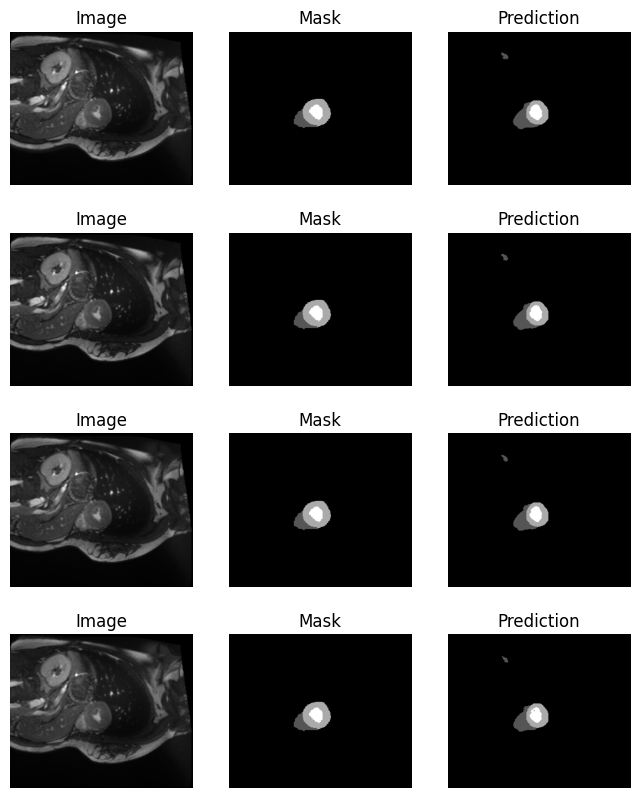

In [10]:
# load the model
model.load_state_dict(torch.load('3DSwinUNETR_best_model.pth'))
model = model.cuda()
model = nn.DataParallel(model)

test_idx = 0
test_dice = 0.0
test_dice1 = 0.0
test_dice2 = 0.0
test_dice3 = 0.0
test_hd1 = 0.0
test_hd2 = 0.0
test_hd3 = 0.0

for data in tqdm(test_loader):
    test_idx += 1
    test_img = data['img']
    test_mask = data['mask']
    test_img = test_img.cuda()
    test_mask = test_mask.cuda()
                
    roi_size = (192, 192, 32)
    sw_batch_size = 4
    test_output = sliding_window_inference(test_img, roi_size, sw_batch_size, model)

    test_output = torch.softmax(test_output, dim=1)
    test_output = torch.argmax(test_output, dim=1, keepdim=True)
    
    dice1, dice2, dice3 = multi_dice_coefficient(test_output.squeeze(), test_mask.squeeze())
    
    hd_output = test_output.squeeze().cpu().detach().numpy()
    hd_mask = test_mask.squeeze().cpu().detach().numpy()

    hd_i = [0.0, 0.0, 0.0]
    for i in range(hd_output.shape[-1]):
        for j in range(3):
            hd_output_i = (hd_output[:,:,i]==j+1)
            hd_mask_i = (hd_mask[:,:,i]==j+1)
            hd_i[j] += directed_hausdorff(hd_output_i, hd_mask_i)[0]
    hd_i[0] = hd_i[0]/hd_output.shape[-1]
    hd_i[1] = hd_i[1]/hd_output.shape[-1]
    hd_i[2] = hd_i[2]/hd_output.shape[-1]
    
    test_dice1 += dice1
    test_dice2 += dice2
    test_dice3 += dice3
    test_hd1 += hd_i[0]
    test_hd2 += hd_i[1]
    test_hd3 += hd_i[2]

# Quantative Results
test_dice1 = test_dice1/test_idx
test_dice2 = test_dice2/test_idx
test_dice3 = test_dice3/test_idx
test_hd1 = test_hd1/test_idx
test_hd2 = test_hd2/test_idx
test_hd3 = test_hd3/test_idx
test_dice = (test_dice1+test_dice2+test_dice3)/3
test_hd = (test_hd1+test_hd2+test_hd3)/3
print('During test, the average Dice: {}, HD: {}mm'.format(test_dice, test_hd))
print('During test, class 1 ave Dice: {}, class 2 ave Dice: {}, class 3 ave Dice: {}'.format(test_dice1, test_dice2, test_dice3))
print('During test, class 1 ave HD: {}mm, class 2 ave HD: {}mm, class 3 ave HD: {}mm'.format(test_hd1, test_hd2, test_hd3))

# Qualitative Results
img_display = test_img.cpu().detach().numpy().squeeze()
mask_display = test_mask.cpu().detach().numpy().squeeze()
output_display = test_output.cpu().detach().numpy().squeeze()

plt.figure(figsize=(8, 10))

plt.subplot(4, 3, 1)
plt.imshow(img_display[:, :, 39], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 2)
plt.imshow(mask_display[:, :, 39], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 3)
plt.imshow(output_display[:, :, 39], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.subplot(4, 3, 4)
plt.imshow(img_display[:, :, 40], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 5)
plt.imshow(mask_display[:, :, 40], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 6)
plt.imshow(output_display[:, :, 40], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.subplot(4, 3, 7)
plt.imshow(img_display[:, :, 41], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 8)
plt.imshow(mask_display[:, :, 41], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 9)
plt.imshow(output_display[:, :, 41], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.subplot(4, 3, 10)
plt.imshow(img_display[:, :, 42], cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(4, 3, 11)
plt.imshow(mask_display[:, :, 42], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(4, 3, 12)
plt.imshow(output_display[:, :, 42], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.savefig('3D_SwinUNETR.png')
plt.show()